# Estimating pi ($\pi$) using Quantum Phase Estimation Algorithm

## 1. Quick overview of the [Quantum Phase Estimation Algorithm](/course/ch-algorithms/quantum-phase-estimation)

Quantum Phase Estimation (QPE) is a quantum algorithm that forms the building block of many more complex quantum algorithms. At its core, QPE solves a fairly straightforward problem: given an operator $U$ and a quantum state $\vert\psi\rangle$ that is an eigenvalue of $U$ with $U\vert\psi\rangle = \exp\left(2 \pi i  \theta\right)\vert\psi\rangle$, can we obtain an estimate of $\theta$?

The answer is yes. The QPE algorithm gives us $2^n\theta$, where $n$ is the number of qubits we use to estimate the phase $\theta$.

## 2. Estimating $\pi$

In this demo, we choose
$$U =  p(\theta), \vert\psi\rangle = \vert1\rangle$$
where 
$$
p(\theta) = \begin{bmatrix}
1 & 0\\ 0 & \exp(i\theta)
\end{bmatrix}
$$
is one of the quantum gates available in Qiskit, and
$$p(\theta)\vert1\rangle = \exp(i\theta)\vert1\rangle.$$ 

 By choosing the phase for our gate to be $\theta =  1$, we can solve for $\pi$ using the following two relations:

1. From the output of the QPE  algorithm, we measure an estimate for $2^n\theta$. Then, $\theta = \text{measured} / 2^n$ 
2. From the definition of the $p(\theta)$ gate above, we know that $2\pi\theta = 1 \Rightarrow \pi = 1 / 2\theta$

Combining these two relations, $\pi = 1 / \left(2 \times (\text{(measured)}/2^n)\right)$. 

For detailed understanding of the QPE algorithm, please refer to the chapter dedicated to it in the Qiskit Textbook located at [qiskit.org/textbook](/course/ch-algorithms/quantum-phase-estimation).

## 3. Time to write code

We begin by importing the necessary libraries.

In [1]:
## import the necessary tools for our work
from IPython.display import clear_output
from qiskit import *
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plotter
from qiskit.tools.monitor import job_monitor
# Visualisation settings
import seaborn as sns, operator
sns.set_style("dark")

pi = np.pi

The function `qft_dagger` computes the inverse Quantum Fourier Transform. For a detailed understanding of this algorithm, see the dedicated chapter for it in the [Qiskit Textbook](/course/ch-algorithms/quantum-fourier-transform).

In [2]:
## Code for inverse Quantum Fourier Transform
## adapted from Qiskit Textbook at
## qiskit.org/textbook

def qft_dagger(circ_, n_qubits):
    """n-qubit QFTdagger the first n qubits in circ"""
    for qubit in range(int(n_qubits/2)):
        circ_.swap(qubit, n_qubits-qubit-1)
    for j in range(0,n_qubits):
        for m in range(j):
            circ_.cp(-np.pi/float(2**(j-m)), m, j)
        circ_.h(j)

The next function, `qpe_pre`, prepares the initial state for the estimation. Note that the starting state is created by applying a Hadamard gate on the all but the last qubit, and setting the last qubit to $\vert1\rangle$.

In [3]:
## Code for initial state of Quantum Phase Estimation
## adapted from Qiskit Textbook at qiskit.org/textbook
## Note that the starting state is created by applying 
## H on the first n_qubits, and setting the last qubit to |psi> = |1>

def qpe_pre(circ_, n_qubits):
    circ_.h(range(n_qubits))
    circ_.x(n_qubits)

    for x in reversed(range(n_qubits)):
        for _ in range(2**(n_qubits-1-x)):
            circ_.cp(1, n_qubits-1-x, n_qubits)

Next, we write a quick function, `run_job`, to run a quantum circuit and return the results.

In [4]:
## Run a Qiskit job on either hardware or simulators

def run_job(circ, backend, shots=1000, optimization_level=0):
    t_circ = transpile(circ, backend, optimization_level=optimization_level)
    qobj = assemble(t_circ, shots=shots)
    job = backend.run(qobj)
    job_monitor(job)
    return job.result().get_counts()

Then, load your account to use the cloud simulator or real devices.

In [5]:
## Load your IBMQ account if 
## you'd like to use the cloud simulator or real quantum devices
my_provider = IBMQ.load_account()
simulator_cloud = my_provider.get_backend('ibmq_qasm_simulator')
device = my_provider.get_backend('ibmq_16_melbourne')

In [6]:
simulator = Aer.get_backend('aer_simulator')

Finally, we bring everything together in a function called `get_pi_estimate` that uses `n_qubits` to get an estimate for $\pi$.

In [7]:
## Function to estimate pi
## Summary: using the notation in the Qiskit textbook (qiskit.org/textbook),
## do quantum phase estimation with the 'phase' operator U = p(theta) and |psi> = |1>
## such that p(theta)|1> = exp(2 x pi x i x theta)|1>
## By setting theta = 1 radian, we can solve for pi
## using 2^n x 1 radian = most frequently measured count = 2 x pi

def get_pi_estimate(n_qubits):

    # create the circuit
    circ = QuantumCircuit(n_qubits + 1, n_qubits)
    # create the input state
    qpe_pre(circ, n_qubits)
    # apply a barrier
    circ.barrier()
    # apply the inverse fourier transform
    qft_dagger(circ, n_qubits)
    # apply  a barrier
    circ.barrier()
    # measure all but the last qubits
    circ.measure(range(n_qubits), range(n_qubits))

    # run the job and get the results
    counts = run_job(circ, backend=simulator, shots=10000, optimization_level=0)
    # print(counts) 

    # get the count that occurred most frequently
    max_counts_result = max(counts, key=counts.get)
    max_counts_result = int(max_counts_result, 2)
    
    # solve for pi from the measured counts
    theta = max_counts_result/2**n_qubits
    return (1./(2*theta))

Now, run the `get_pi_estimate` function with different numbers of qubits and print the estimates.

In [8]:
# estimate pi using different numbers of qubits
nqs = list(range(2,12+1))
pi_estimates = []
for nq in nqs:
    thisnq_pi_estimate = get_pi_estimate(nq)
    pi_estimates.append(thisnq_pi_estimate)
    print(f"{nq} qubits, pi ≈ {thisnq_pi_estimate}")

Job Status: job is actively running

Job Status: job has successfully run
2 qubits, pi ≈ 2.0
Job Status: job is being initialized

Job Status: job has successfully run
3 qubits, pi ≈ 4.0
Job Status: job is being initialized

Job Status: job has successfully run
4 qubits, pi ≈ 2.6666666666666665
Job Status: job is being initialized

Job Status: job has successfully run
5 qubits, pi ≈ 3.2
Job Status: job is being initialized

Job Status: job has successfully run
6 qubits, pi ≈ 3.2
Job Status: job is being initialized

Job Status: job has successfully run
7 qubits, pi ≈ 3.2
Job Status: job is being initialized

Job Status: job has successfully run
8 qubits, pi ≈ 3.1219512195121952
Job Status: job is being initialized

Job Status: job has successfully run
9 qubits, pi ≈ 3.1604938271604937
Job Status: job is being initialized

Job Status: job has successfully run
10 qubits, pi ≈ 3.1411042944785277


Job Status: job is being initialized

Job Status: job has successfully run
11 qubits, pi ≈ 3.1411042944785277


Job Status: job is being initialized

Job Status: job has successfully run
12 qubits, pi ≈ 3.1411042944785277


And plot all the results.

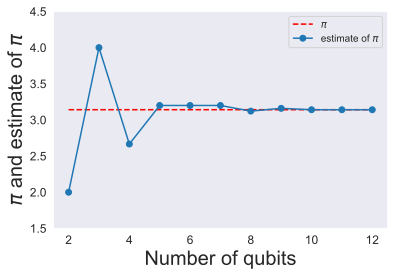

In [9]:
plotter.plot(nqs, [pi]*len(nqs), '--r')
plotter.plot(nqs, pi_estimates, '.-', markersize=12)
plotter.xlim([1.5, 12.5])
plotter.ylim([1.5, 4.5])
plotter.legend(['$\pi$', 'estimate of $\pi$'])
plotter.xlabel('Number of qubits', fontdict={'size':20})
plotter.ylabel('$\pi$ and estimate of $\pi$', fontdict={'size':20})
plotter.tick_params(axis='x', labelsize=12)
plotter.tick_params(axis='y', labelsize=12)
plotter.show()

In [10]:
import qiskit.tools.jupyter
%qiskit_version_table